In [ ]:
pacman::p_load(DESeq2,dplyr,tidyverse,BUSpaRse,ape,tximport)

Only run this if you have not previously installed `DESeq2` with `Bioconductor` (i.e., if you run the line above and you get an error). In this case, you should re-run the above `pacman` command after having installed `Bioconductor` and/or `pacman`. 

In [ ]:
BiocManager::install("DESeq2")
install.packages("pacman")
library(pacman)
BiocManager::install("BUSpaRse")

**Note**: All of the experimental data being used as part of this tutorial have been provided from:

White, R. J., Collins, J. E., Sealy, I. M., Wali, N., Dooley, C. M., Digby, Z., ... & Busch-Nentwich, E. M. (2017). A high-resolution mRNA expression time course of embryonic development in zebrafish. Elife, 6, e30860.

## Reading in the existing count matrix from the provided output

_All of the files read in during this section have been provided in the supplemental data of the paper_.

Read in the count matrix containing the counts for each of the relevant stages of development that we are interested in. We're going to use the available count matrix rather than the TPM matrix, because `DESeq2` expects data in this format. Later, we'll use `tximport` to read in `Salmon` quantification output directly. When we use direct `Salmon` information, we know what length the assessed isoform gene is, so we can get accurate TPM value estimates. Check the following [link](http://www.bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#why-un-normalized-counts) for more information on this, in particular why `DESeq2` expects either counts or full `Salmon` output, but not TPM!

In [ ]:
# Raw count matrix
counts_matrix <- read.csv(file.path("..","subsampled-data","count-matrix-e89.csv"))
# Metadata about the samples
metadata_matrix <- read.csv(file.path("..","subsampled-data","sample-info.tsv"),sep="\t")
# TPM measurements rather than raw counts
tpm_matrix <- read.csv(file.path("..","subsampled-data","sample-tpm-e90.csv"))

Let's make the filenames consistent.

In [ ]:
colnames(counts_matrix) = gsub("\\.", "-", gsub("X", "", colnames(counts_matrix)))

## Plotting TPM values from Supplemental Data outside of `DESeq2`

Before we do anything with the software `DESeq2`, let's see what we can do with the TPM matrix that was provided directly as part of the supplemental data from the paper. TPM stands for _transcripts per million_, and it's a normalized estimate of the abundance of each of the transcripts based upon the size of each transcript and the total number of transcripts in the raw data of each of the files. 

TPM = $ \frac{\frac{\textrm{reads mapped to gene} \times 10^3}{\textrm{gene length}} \times 10^6}{\Sigma \frac{\textrm{reads mapped to gene} \times 10^3}{\textrm{gene length}}}$


In panel A below, we can see the log-normalized expression profiles of 127 genes and their TPM from the paper.


![Differential expression info](../images/lax_30860_elife-30860-fig7-v1.tif.jpg)

We're only going to look at a subset of these expression profiles, but let's start to get a sense of how things differ (and some practice with plotting).

In [ ]:
# First, we'll convert the existing TPM matrix into a "melted" one
melted_tpm = tpm_matrix %>% pivot_longer(cols = starts_with("X") | starts_with("Day"))

The `pivot_longer` function turns the relevant rows into separate columns for each of the treatments, so that we can plot things using single variables. 

![Differential expression info](../images/tidy-pivoting-longer.png)

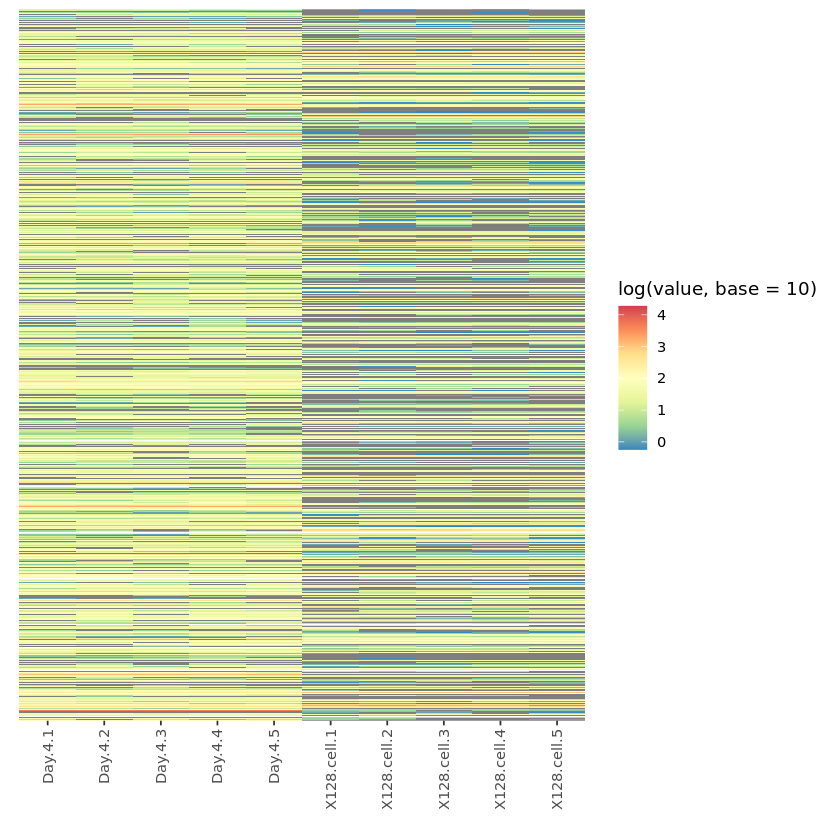

In [13]:
ggplot(melted_tpm) + geom_tile(aes(x = name, y = gene_id, fill = log(value,base=10))) + 
    scale_fill_distiller(palette = "Spectral") + theme(axis.ticks.y = element_blank(),
                                                       axis.title.y = element_blank(),
                                                       axis.text.y = element_blank()) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + xlab("")

In the above plot, we can see that overall expression levels appear to be higher at Day 4 of larval development vs. the 128-cell blastula. However, we could do a better job of investigating the differential expression of individual genes using the raw TPM data. To do this, let's organize by putting the "genes" with the lowest expression in the 128-cell blastula towards the top of the the matrix by reorganizing the factors. 

**Factors** in R control the order in which we view categorical data.

`summarise()` has grouped output by 'gene_id'. You can override using the `.groups` argument.



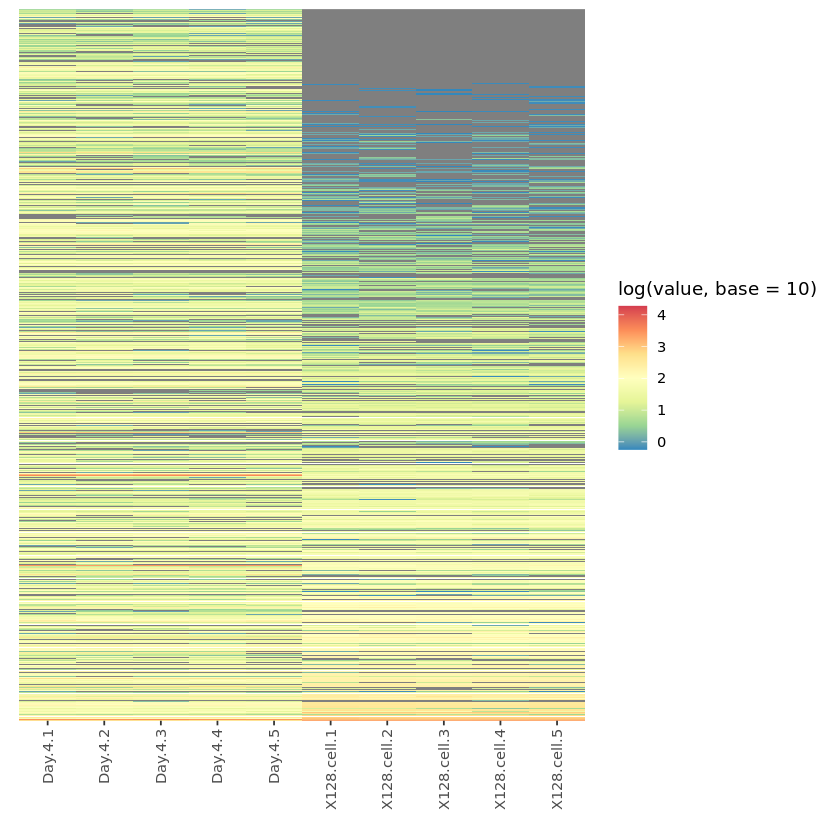

In [28]:
gene_id_orders = (melted_tpm %>% dplyr::mutate(stage = case_when(grepl("128",name) ~ "blastula",
                                               grepl("Day",name) ~ "dayfour")) %>%
    dplyr::group_by(gene_id,stage) %>% dplyr::summarize(value = mean(value,na.rm=T)) %>%
    dplyr::filter(stage == "blastula") %>%
    dplyr::arrange(desc(value)))$gene_id
melted_tpm$ordered_gene_id = factor(melted_tpm$gene_id, levels = gene_id_orders)

ggplot(melted_tpm) + geom_tile(aes(x = name, y = ordered_gene_id, fill = log(value,base=10))) + 
    scale_fill_distiller(palette = "Spectral") + theme(axis.ticks.y = element_blank(),
                                                       axis.title.y = element_blank(),
                                                       axis.text.y = element_blank()) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + xlab("")

Or ordering by the lowest expression level in both stages at once.

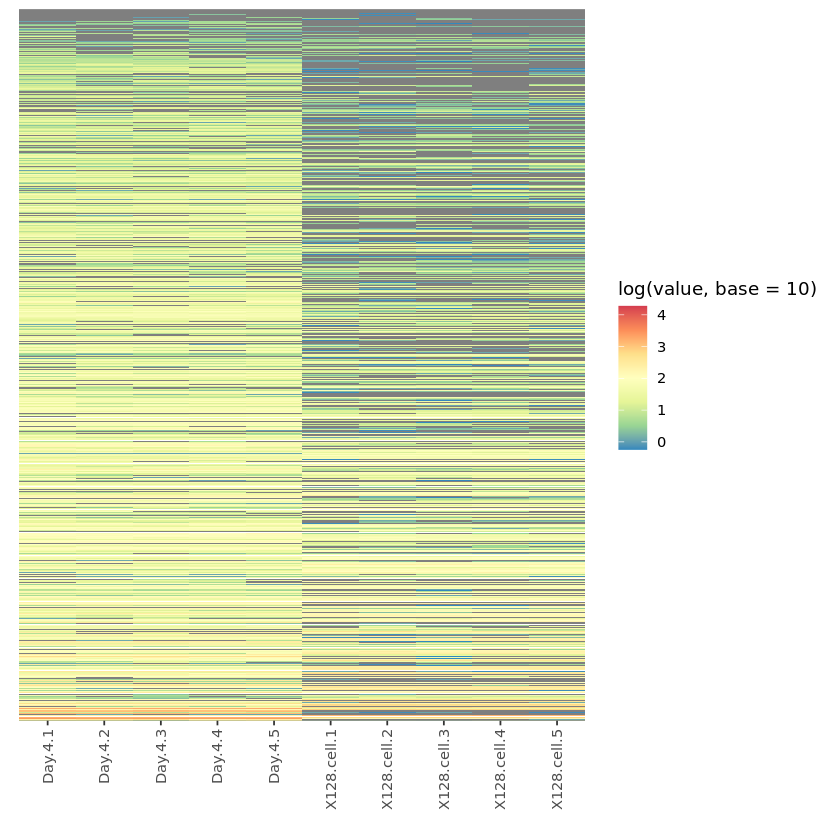

In [32]:
gene_id_orders = (melted_tpm %>% dplyr::mutate(stage = case_when(grepl("128",name) ~ "blastula",
                                               grepl("Day",name) ~ "dayfour")) %>%
    dplyr::group_by(gene_id) %>% dplyr::summarize(value = mean(value,na.rm=T)) %>%
    dplyr::arrange(desc(value)))$gene_id
melted_tpm$ordered_gene_id = factor(melted_tpm$gene_id, levels = gene_id_orders)

ggplot(melted_tpm) + geom_tile(aes(x = name, y = ordered_gene_id, fill = log(value,base=10))) + 
    scale_fill_distiller(palette = "Spectral") + theme(axis.ticks.y = element_blank(),
                                                       axis.title.y = element_blank(),
                                                       axis.text.y = element_blank()) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + xlab("")

**Challenge 1**: Try to order the plot according to the highest expression level across samples in the day 4 larval samples.

A couple of substantially varying transcripts are specifically labeled in the line plot in panel B of the paper from the figure. Let's identify one of those genes and compare its expression across replicates in the 128-day blastula vs. day 4 larval phase.

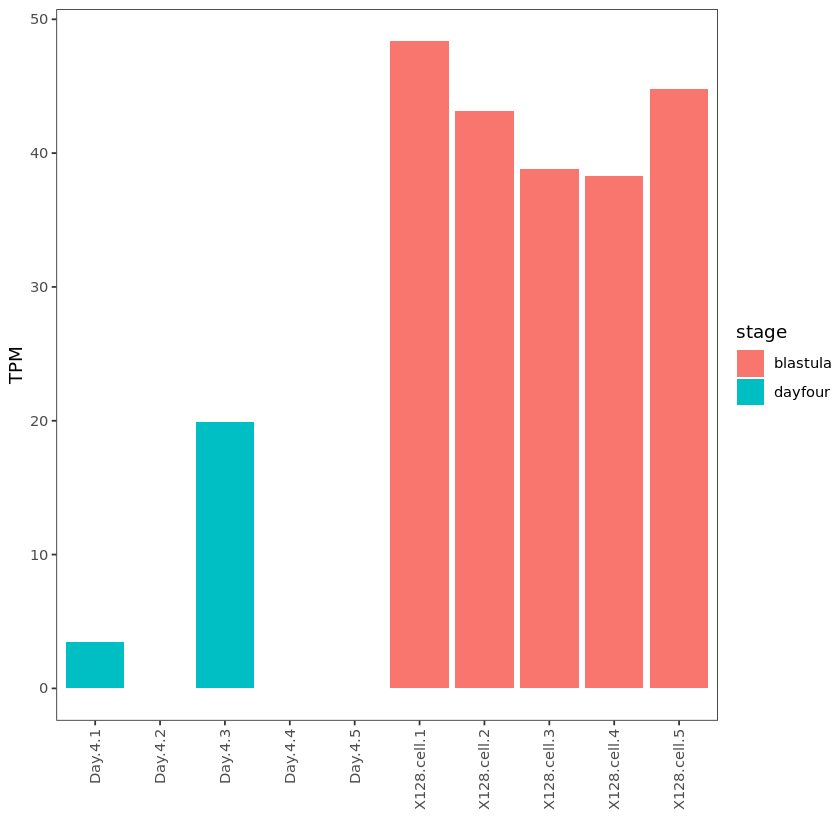

In [43]:
# ENSDAR00000045555
transcript_1 = melted_tpm %>% dplyr::mutate(stage = case_when(grepl("128",name) ~ "blastula",
                                               grepl("Day",name) ~ "dayfour")) %>%
    dplyr::filter(transcript_id == "ENSDART00000045555" )
ggplot(transcript_1) + geom_bar(aes(x = name, y = value, fill = stage, group = stage), 
                                stat = "identity") + theme_test() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + xlab("") + ylab("TPM")

We can see that, as shown in the plot that the authors provide, the expression of this particular transcript is quite high in the 128-day blastula phase (and all phases of early development), but almost nonexistent by day 4 of the larval phase.

**Challenge 2**: identify the differences in expression in transcript ENSDAR000000138294, also indicated in the panel figure from the manuscript.

## Read in `DESeq2` count data object
We set out design to be looking for fold changes in differential expression that are related to the name of the stage (`stageName`), since that identifies the major thing that is different between samples.

**Note**: if we did not have this count matrix already generated for us, we would use `tximport` directly with the `Salmon` data as a means to read in the quantification files. We will do that next with the provided `Salmon` output from an existing quantification run of `Salmon`.

Before we do this, we should check that the column names of what we're reading in match the rows of our metadata.

In [ ]:
colnames_todeseq = colnames(counts_matrix %>% dplyr::select(starts_with("128") | 
                                                            starts_with("Day"))) # the non-metadata columns!
rownames_todeseq = as.character(metadata_matrix$sampleName)

colnames_todeseq == rownames_todeseq

If all of the comparisons above return TRUE, meaning that we have total correspondence between our sample entries, we're good to go and can keep getting things set up.

**Note**: the rows of the count matrix are the "genes"/transcripts of interest, and the columns are the expression of each of the genes in the replicate samples for the two developmental stages of interest.

## Create a `DESeq2` object from the count matrix

In [ ]:
deseq_larval <- DESeqDataSetFromMatrix(countData = counts_matrix %>% dplyr::select(starts_with("128") | 
                                                                                   starts_with("Day")), 
                                       colData = metadata_matrix, design = ~stageName)

Ignore the warning about the column names. Now let's inspect the `DESeq2` object that was created.

In [ ]:
deseq_larval

## Pre-filter the `DESeq2` object to remove those transcripts with very low counts

Now we can pre-filter the `DESeq2` object based on genes that have very low counts. This makes the process less memory-intensive (we avoid wasting time on things that are very rare to begin with).

In [ ]:
print(nrow(counts(deseq_larval)))
keep <- rowSums(counts(deseq_larval)) >= 10
deseq_larval <- deseq_larval[keep,]

### Question 1: how does the number of counts of `deseq_larval` change?

How many rows are left of the count matrix? How does that change if we modify the threshold for the counts (right now it's set to 10) to a higher or a lower number?

## Differential expression calculations

Next, we'll run `DESeq2` as a combined command. 

**Note** that this command does a few things all wrapped into one. All of these functions can also be performed completely separately within `DESeq2`. The steps are:
- Estimate size factors
- Estimate dispersion
- Gene-wise calculation of dispersion
- Mean dispersion relationship
- Estimate final dispersion
- Test model.

In [ ]:
deseq_larval = DESeq(deseq_larval)

### Parsing the results from the `DESeq2` object

We can parse the results out of this complex object generated by `DESeq2` using the `results` command.

In [ ]:
results_fr <- results(deseq_larval)
results_fr

### Question 2: What do you see inside of this object?
- How many columns are there?
- How many rows? How does this compare to the number of rows we retained using the above threshold for the number of counts we wanted to keep?

## The log-fold change

The above introduces us to the idea of the _log-fold change_. Here, we're comparing the change in expression of larval stage day 4 to the expression during the 128-cell blastula phase. It's important to remember that the version of the log-fold change presented in `DESeq2` is just one version (Zhu, A., Ibrahim, J.G., Love, M.I. (2018) from `apeglm`, scaled to data and zero-centered), and many other means exist for doing this (alternative "shrinkage estimators") exist. Basically, what shrinkage estimators do is cinch in the extreme values towards a more stable mean.

After normalizing to the overall size of the matrix and the expression of each gene, we are interested in seeing what the comparative change is in expression between the two states, and we obtain a probability ("p-value") for how likely it would be to see that kind of a change in expression by chance. This "p-value" is like a typical adjusted threshold for how likely we would be to find a similar change in expression by chance. In general, we set a threshold like 0.05 for this value.

Next, we can organize our results by p-value (we want to focus on the results that are (a) significant and (b) highly significant). 

In [ ]:
# Order results dataframe by p-value.
resOrdered <- results_fr[order(results_fr$pvalue),]

In [ ]:
# Check how many results are significant at a p-value of 0.05
sum(resOrdered$padj < 0.05, na.rm=TRUE)

### Question 3:  How many transcripts are significantly differentially expressed at the p = 0.05 value?
- How does this compare to the total number of transcripts/features?
- How does this change as we modify the significance value?

## Variance-stabilizing transformation (VST) 
The problem with count data is that we have many relatively low counts and some counts that are extremely high. We need a transformation that will enable us to separate the **variance** from the **mean**. This is an alternative method that eliminates our need to use *pseudo-counts*, wherein we add some constant to our $\log$ normalization to control for zero values ($\log_2 (n + x)$, where $n$ are our counts and $x$ is some constant).

The `blind` parameter to this function determines whether we should be blind to the experimental design we specified. In our case, that would mean we would be treating the two larval phases as something like replicates, and not expecting to find variability due to the design we specified when we calculated the differential expression. We set this parameter to `FALSE`, because we do expect there to be some differences between treatments. If this is set to `TRUE`, we don't compute the dispersions differently for the two sub-populations.

In [151]:
vsd <- vst(deseq_larval, blind=FALSE)

### Plotting a PCA of the data
Now that we have variance-stabilized counts from `DESeq2` (that it treats internally with a GLM), we can compare our samples both in terms of extracting the significantly differentially-expressed genes, as well as comparing our sample treatments. To view the difference between these two treatments in space from our counts, we can create a principal components analysis plot.

In [ ]:
pcaData <- plotPCA(vsd, intgroup=c("stageName"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"),3)
ggplot(pcaData %>% dplyr::mutate(rep = as.numeric(vapply(strsplit(as.character(name),"-"), 
                                              `[`, 3, FUN.VALUE=character(1)))), 
       aes(PC1, PC2, color=stageName, size=rep)) +
  geom_point() +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + theme_test()

### **Question 4**: Does this look reasonable? How should PCA be interpreted?

If we're only comparing two conditions, would we expect all of the variability to be explained by one variable? Does this mean the data are colinear?

Let's plot the size factors from the individual stages to see how they compare between treatments.

In [ ]:
ggplot(data.frame(colData(deseq_larval))) + geom_boxplot(aes(x = stageName, y = sizeFactor), 
                                                         fill = "light blue",
                                                         col = "black") + theme_test(base_size=15)

## Loading in data from the output of `Salmon`

In the case of this paper, the authors provided both neat counts and neat normalized expression values in TPM for their samples. However, when conducting your own analysis, you will need to perform the quantification step with `Salmon` or another tool, and then format the counts in a way that makes sense. We can use `tximport` to import the output of our `Salmon` run and format it accordingly. 

### Creating a transcript-to-gene correspondance

Before we can actually use `tximport` on the output of our `Salmon` runs, we actually first need to read in the Ensembl-based package containing the zebrafish ( _Danio rerio_ ) genome sequences and their correspondences to transcriptome sequences. This is because we need to be able to tell `tximport` how transcripts match up to the genes that we are aligning them to from the reference genome. 

You'll notice that in the above read-in of files from the paper, they have already included this information for us! Note that we can also use libraries, e.g. `TxDb.Drerio.UCSC.danRer11.refGene`, to do this (but the ensembl database is in a bit of transition at the moment).

In [104]:
txdb = makeTxDbFromGFF(file.path("..","complete-sequence-data","Danio_rerio.GRCz11.104.gff3.gz"))

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .extract_exons_from_GRanges(exon_IDX, gr, mcols0, tx_IDX, feature = "exon", :
"246 exons couldn't be linked to a transcript so were dropped (showing
  only the first 6):
  seqid    start      end strand   ID               Name
1    14 22455575 22455834      - <NA> ENSDARE00001184520
2    16 10255207 10255282      - <NA> ENSDARE00001222173
3    16 10260982 10261135      - <NA> ENSDARE00001150006
4    16 10261501 10261625      - <NA> ENSDARE00001178487
5     2 31856242 31856582      - <NA> ENSDARE00001169491
6     2 31856899 31856985      - <NA> ENSDARE00001216676
                         Parent Parent_type
1 transcript:ENSDART00000169163        <NA>
2 transcript:ENSDART00000167870        <NA>
3 transcript:ENSDART00000167870        <NA>
4 transcript:ENSDART00000167870        <NA>
5 transcript:ENSDART00000159824        <NA>
6 transcript

In [189]:
txfile = read.gff(file.path("..","complete-sequence-data","Danio_rerio.GRCz11.104.gff3.gz"), 
                  na.strings = c(".", "?"), GFF3 = TRUE)

Now let's manipulate the GFF file a bit in order to get our gene and transcript names out easily.

In [194]:
txfile = txfile %>%
    dplyr::mutate(gene_id = case_when(grepl("Name",attributes) ~
                                      vapply(strsplit(as.character(attributes),"Name="), 
                                              `[`, 2, FUN.VALUE=character(1)),
                                      TRUE ~ "")) %>%
    dplyr::mutate(transcript = case_when(grepl("transcript",attributes) ~ 
                                         vapply(strsplit(as.character(attributes),"transcript:"), 
                                              `[`, 2, FUN.VALUE=character(1)),
                                      TRUE ~ "")) %>%
    dplyr::mutate(gene_id =  vapply(strsplit(as.character(gene_id),";"), 
                                              `[`, 1, FUN.VALUE=character(1)),
                  transcript =  vapply(strsplit(as.character(transcript),";"), 
                                              `[`, 1, FUN.VALUE=character(1)))

Let's clean up our transcript-to-gene file a little bit by removing `NA` values and writing only our columns of interest.

In [ ]:
write.csv(txfile %>% dplyr::filter(!is.na(transcript) & !is.na(gene_id)) %>% 
          dplyr::select(transcript,gene_id), file.path("..","salmon-output","transcript_to_gene.csv"))

### Read in `Salmon` output files from `salmon quant`

In [ ]:
# The base folder where our `Salmon` results are located.
salmon_basefolder <- file.path("..","salmon-output",c("salmon_blastula-128-cell","salmon_larval-day-5"))
# A listing of all of the folders in these directories
salmon_files = c()
salmon_filenames = c()
for (sf in salmon_basefolder) {
    salmon_files = c(salmon_files,file.path(list.dirs(sf,recursive=F),"quant.sf"))
    salmon_filenames = c(salmon_filenames,list.dirs(sf,recursive=F,full.names=F))
}
names(salmon_files) <- salmon_filenames

Now to read in the transcript-to-gene file.

In [ ]:
tx2gene <- read.csv(file.path("..","salmon-output","transcript_to_gene.csv"),row.names=1)

Now, we can finally actually `tximport` the files of interest!

In [ ]:
txi <- tximport(salmon_files, type = "salmon", tx2gene = tx2gene, ignoreTxVersion = TRUE)

In [210]:
# Examine what is available in tximport object
names(txi)

[1] "abundance"           "counts"              "length"             
[4] "countsFromAbundance"

In [212]:
# inspect the count matrix
head(txi$counts)

,salmon_quant_ERR1442811,salmon_quant_ERR1442812,salmon_quant_ERR1442813,salmon_quant_ERR1442814,salmon_quant_ERR1442815,salmon_quant_ERR1442771,salmon_quant_ERR1442772,salmon_quant_ERR1442773,salmon_quant_ERR1442774,salmon_quant_ERR1442775
a1cf-201,0,0,0,0,0,40.000,47.000,45.000,43.000,43.000
a2ml-201,0,0,0,2,0,206.625,196.681,219.201,208.279,227.604
a2ml-202,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000
aaas-201,5,5,2,3,4,2.000,3.000,1.000,3.000,0.000
aacs-201,38,52,47,33,27,0.000,0.000,0.000,2.000,10.000
aacs-202,0,0,0,0,0,7.000,9.000,10.000,0.000,0.000


### Run `DESeq2` using the `Salmon` output

In [ ]:
salmon_deseq2 <- DESeqDataSetFromTximport(txi, metadata_matrix, ~stage)
salmon_deseq2 <- DESeq(salmon_deseq2)

In [224]:
salmon_deseq2_res <- results(salmon_deseq2)

head(salmon_deseq2_res[order(salmon_deseq2_res$pvalue),])

log2 fold change (MLE): stage Larval.Day.4 vs Blastula.128.cell 
Wald test p-value: stage Larval.Day.4 vs Blastula.128.cell 
DataFrame with 6 rows and 6 columns
                    baseMean   log2FoldChange              lfcSE
                   <numeric>        <numeric>          <numeric>
actb1-201    1353.0561989704  3.4615577682996 0.0640496455725298
actb2-201    3287.6169644418 2.51142831918962 0.0384902288533923
actc1b-202  12300.5578947532 12.5017994853845  0.249262602619936
ahnak-201   393.249650672872 2.99640981260904 0.0748009888226469
atp5f1b-201 1470.59752098023 3.85193703816809  0.048347692682513
atp5fa1-201 1245.43833066237 2.90830561307346 0.0442260390344884
                        stat    pvalue      padj
                   <numeric> <numeric> <numeric>
actb1-201   54.0449168353278         0         0
actb2-201   65.2484641947842         0         0
actc1b-202  50.1551350021272         0         0
ahnak-201    40.058425159506         0         0
atp5f1b-201  79.671579437

### Challenge 2: Go through downstream steps of `DESeq2`
- Investigate how output using our own `Salmon` run differs from provided data from paper supplement. 